In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (<ipython-input-3-583db37e43a6>, line 17)

In [4]:
import numpy as np
import os
import glob
import time

# importing data
event_types = {1:'GRB',2:'TGF',3:'SGR',4:'SFLARE'}

test_dir = os.path.join('/kaggle/input/dcl-ds2new/DCL_ds2new/test')  
train_dir = os.path.join('/kaggle/input/dcl-ds2new/DCL_ds2new/train')

# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'

search_pattern = os.path.join(test_dir, f'*{search_string}*')
all_test_files = glob.glob(search_pattern)
test_files = [file for file in all_test_files if not file.endswith('d')]

search_pattern = os.path.join(train_dir, f'*{search_string}*')
all_train_files = glob.glob(search_pattern)
train_files = [file for file in all_train_files if not file.endswith('d')]

print(len(test_files))
print(test_files[:10])

print(len(train_files))
print(train_files[:10])
import json

json_data_path = '/kaggle/input/dcl-ds2new/DCL_ds2new/params.json'
with open(json_data_path, 'r') as file:
    try:
        json_data = json.load(file)
        print(json_data)
    except json.JSONDecodeError:
        print(f"Error: JSON decode failed for file '{file_path}'")


692
['/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn170113420', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn141216438', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn131029420', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn171010875', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SGR_bn160715298', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn220407167', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/TGF_bn140628393', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/TGF_bn180607061', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/TGF_bn180922713', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn140204056']
2800
['/kaggle/input/dcl-ds2new/DCL_ds2new/train/SGR_bn160626724', '/kaggle/input/dcl-ds2new/DCL_ds2new/train/GRB_bn230911329', '/kaggle/input/dcl-ds2new/DCL_ds2new/train/TGF_bn160416676', '/kaggle/input/dcl-ds2new/DCL_ds2new/train/GRB_bn150322066', '/kaggle/input/dcl-ds2new/DCL_ds2new/train/GRB_bn120312671', '/kaggle/input/dcl-ds2new/DCL_ds2new/train/TGF_bn110606097', '/kaggle/input

In [5]:
dno = json_data['number of data points']

try:
    chrn = len(json_data['channel ranges'])
except:
    chrn = 1
    
try:
    t = json_data['time interval'][1]-json_data['time interval'][0]
except:
    t='n/a'
    
# Calculating the number of points in each binnning
bin_list = json_data['bin list']
dno_list = (chrn * len(bin_list)) * [dno]
data_total = sum(dno_list)
check_data = np.loadtxt(train_files[1], delimiter='\t').astype(np.int32)
len_data = len(check_data)
print(dno_list)

if data_total == len_data and len(dno_list) == len(bin_list) * chrn:
    print('bin edges calculated correctly')
else:
    print('inconsistency in bin edges calculated and data')
    print(data_total)
    print(len_data)
    
print('channel range no',chrn)
print('number of data points',dno)
print('time interval',t)

[499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499]
bin edges calculated correctly
channel range no 2
number of data points 499
time interval n/a


In [6]:
import numpy as np

def process_file(file, X, Y, event_counter, dno_list):
    """
    Processes a single file and adds its data to the dataset.
    file: path to the file to be processed
    X: list of datasets to be appended to
    Y: list of labels of data
    event_counter: dictionary counting events
    dno_list: list of number of data points in each binning as calculated previously
    
    Returns updated X, Y, and event_counter
    """
    # Fetch data from file and check if label is considered
    event_type, event_name = file.split('/')[-1].split('_')
    loaded_data = np.loadtxt(file, delimiter='\t').astype(np.int32)
    
    if event_type not in event_counter:
        return X, Y, event_counter
    
    y = [0, 0, 0, 0]
    
    # Setting and updating Y
    for key, value in event_types.items():
        if value in file.split('\\')[-1]:
            y[key - 1] = 1
            Y.append(y)
            event_counter[value] += 1
    
    channel_1_data = []
    channel_2_data = []

    # Initialize lists to hold data slices
    for i in range(0,len(loaded_data),998):
        channel_1_data.extend(loaded_data[i:i+499])
        channel_2_data.extend(loaded_data[i+499:i+998])
    
    X.append([channel_1_data, channel_2_data])
    
    return X, Y, event_counter

In [7]:
# initializing train and test sets
X_train = []
Y_train = []
train_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

X_test = []
Y_test = []
test_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

# print(process_file(train_files[1],X_train,Y_train,train_event_counter))

# processing train and test data sets
for file in train_files:
    X_train,Y_train,train_event_counter = process_file(file,X_train,Y_train,train_event_counter,dno_list)
print('training events\n',train_event_counter)
print('total events : ', sum([i for i in train_event_counter.values()]))
Y_train = np.array(Y_train)
X_train = np.array(X_train)
print('shape of Y_train', Y_train.shape)
print('shape of X_train', X_train.shape)

for file in test_files:
    X_test,Y_test,test_event_counter = process_file(file,X_test,Y_test,test_event_counter,dno_list)
print('testing events\n',test_event_counter)
print('total events : ', sum([i for i in test_event_counter.values()]))
Y_test = np.array(Y_test)
X_test = np.array(X_test)
print('shape of Y_test', Y_test.shape)
print('shape of X_test', X_test.shape)
print(X_train[1:2])


training events
 {'GRB': 800, 'TGF': 800, 'SGR': 400, 'SFLARE': 800}
total events :  2800
shape of Y_train (2800, 4)
shape of X_train (2800, 2, 3493)
testing events
 {'GRB': 200, 'TGF': 200, 'SGR': 92, 'SFLARE': 200}
total events :  692
shape of Y_test (692, 4)
shape of X_test (692, 2, 3493)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [8]:
import tensorflow as tf
from keras import layers, models,regularizers,Sequential
from keras.callbacks import EarlyStopping , ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, LSTM, GRU, Bidirectional,BatchNormalization

In [9]:
tf.random.set_seed(42)

# Build the CNN model
model = Sequential()
#model.add(layers.Conv1D(32, 1, activation='relu', input_shape=(2,3493),kernel_regularizer=regularizers.l2(0.03)))

model.add(Input(shape=(2,3493)))

model.add(layers.Conv1D(1024,2, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.MaxPooling1D((1)))
model.add(LSTM(1024, return_sequences=True ,kernel_regularizer=regularizers.l2(0.02)))


model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.03)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(layers.Dense(4, activation='softmax'))
model.summary()

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3,min_lr=1e-6,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',patience=25,min_delta=0.001, restore_best_weights=True, verbose=1)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epoch = 100
# Train the model
history = model.fit(X_train, Y_train, epochs=epoch, batch_size=64, validation_split=0.2, callbacks=[lr_scheduler, early_stopping])#,callbacks=[custom_early_stopping])

# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f'\n accuracy on training data: {train_acc} \n \n')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print(f'accuracy on test data: {test_acc}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 1024)             │       7,154,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,860,420 (64.32 MB)

 Trainable params: 16,860,420 (64.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5885 - loss: 78.5294 - val_accuracy: 0.7286 - val_loss: 21.2113 - learning_rate: 0.0010
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7505 - loss: 16.4427 - val_accuracy: 0.7179 - val_loss: 8.4924 - learning_rate: 0.0010
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7210 - loss: 7.5446 - val_accuracy: 0.7589 - val_loss: 5.5215 - learning_rate: 0.0010
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7508 - loss: 5.1659 - val_accuracy: 0.7732 - val_loss: 4.2649 - learning_rate: 0.0010
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7499 - loss: 4.0229 - val_accuracy: 0.7786 - val_loss: 3.4734 - learning_rate: 0.0010
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7662 - loss: 3.3983 - val_accuracy: 0.7679 - val_loss: 3.1812 - learning_rate: 0.0010
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7467 - loss: 3.1321

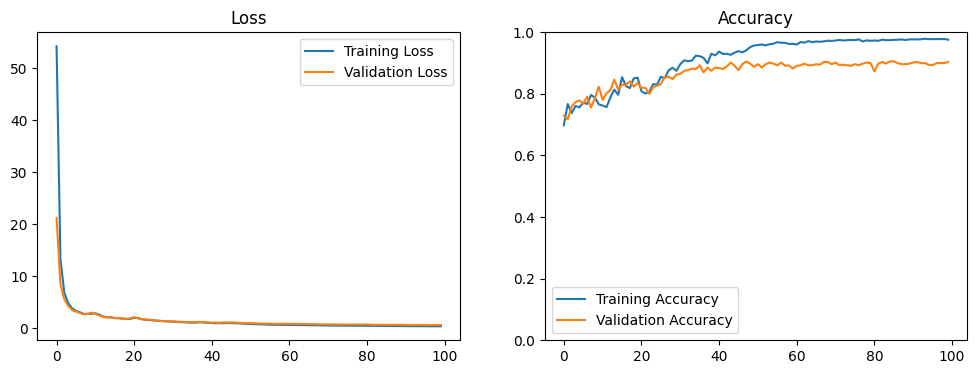

accuracy on test data: 0.900288999080658


In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
#plt.ylim(0, 100)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.ylim(0, 1) 
plt.show()
print(f'accuracy on test data: {test_acc}')

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


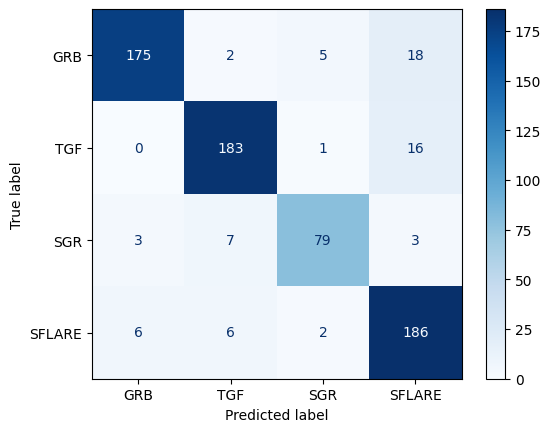

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = ['GRB', 'TGF', 'SGR', 'SFLARE']

test_prediction = model.predict(X_test)
test_predicted_label = np.argmax(test_prediction, axis=1)
test_actual_label = np.argmax(Y_test, axis = 1)
conf_m = confusion_matrix(test_actual_label, test_predicted_label)

conf_m_show = ConfusionMatrixDisplay(confusion_matrix = conf_m,display_labels=class_labels)
conf_m_show.plot(include_values=True, cmap='Blues',ax = None, xticks_rotation= 'horizontal')
plt.show()

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


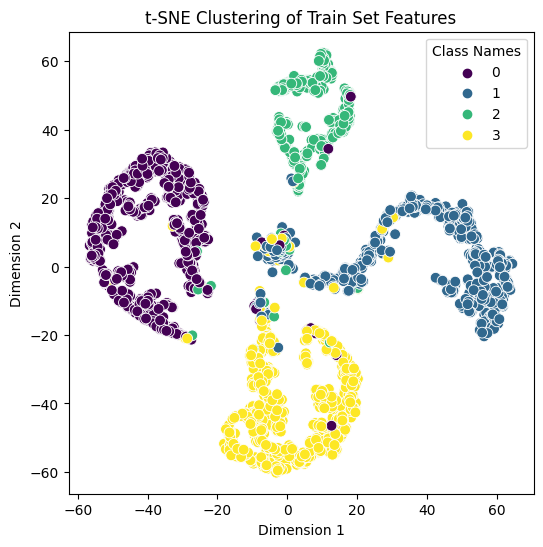

In [12]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Extract features from the penultimate layer
intermediate_layer_model = models.Model(inputs=model.inputs, outputs=model.layers[-2].output)
features = intermediate_layer_model.predict(X_train)

# Reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)
y_true = np.argmax(Y_train, axis=1)

class_names = ['GRB', 'TGF', 'Sgr', 'Sflare']

# Plot the 2D features
plt.figure(figsize=(6, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=y_true, palette="viridis", s=60)

plt.legend(title='Class Names', labels=class_names)
plt.title("t-SNE Clustering of Train Set Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title = 'Class Names')
plt.show()


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


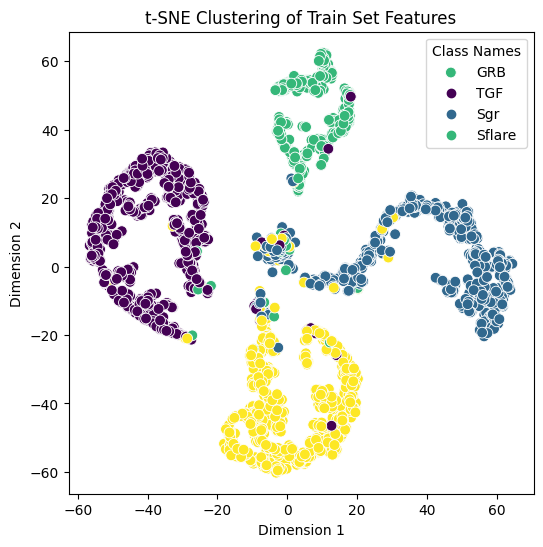

In [13]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming model and X_train, Y_train are already defined

# Extract features from the penultimate layer
intermediate_layer_model = models.Model(inputs=model.inputs, outputs=model.layers[-2].output)
features = intermediate_layer_model.predict(X_train)

# Reduce to 2 dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Get the true labels (indices)
y_true = np.argmax(Y_train, axis=1)

# Class names (to be mapped to the numeric labels)
class_names = ['GRB', 'TGF', 'Sgr', 'Sflare']

# Create a dictionary to map numeric labels to class names
label_mapping = {i: class_names[i] for i in range(len(class_names))}

# Plot the 2D features
plt.figure(figsize=(6, 6))

# Map the numeric labels to the corresponding class names for the hue
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=y_true, palette="viridis", s=60)

# Set the legend with class names
plt.legend(title='Class Names', labels=[label_mapping[i] for i in range(len(class_names))])

# Customize plot
plt.title("t-SNE Clustering of Train Set Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Accuracy on training data with unidentified class: 0.9571428571428572


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Yes
Accuracy on test data with unidentified class: 0.8930635838150289
Number of unidentified instances in training data: 34
Number of unidentified instances in test data: 16
confusion matrix


<Figure size 1000x700 with 0 Axes>

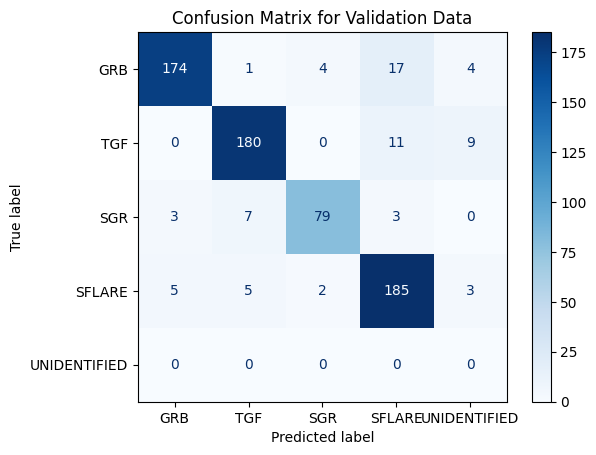

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

threshold = 0.6


def predict_with_unidentified(model, data, threshold=0.6):
    predictions = model.predict(data)
    max_prob = np.max(predictions, axis=1)
    labels = np.argmax(predictions, axis=1)
    labels[max_prob < threshold] = 4
    
    unidentified_count = np.sum(max_prob < threshold)
    return labels, unidentified_count

# Evaluate on training data
train_predictions, train_unidentified_count = predict_with_unidentified(model, X_train, threshold)
train_accuracy = np.mean(train_predictions == np.argmax(Y_train, axis=1))
print(f'\nAccuracy on training data with unidentified class: {train_accuracy}\n\n')

# Evaluate on validation data
test_predictions, test_unidentified_count = predict_with_unidentified(model, X_test, threshold)

# Check if Y_test is one-hot encoded or not
if Y_test.ndim > 1:
    print("Yes")
    test_true_labels = np.argmax(Y_test, axis=1)
else:
    test_true_labels = Y_test

test_accuracy = np.mean(test_predictions == test_true_labels)
print(f'Accuracy on test data with unidentified class: {test_accuracy}')

print(f'Number of unidentified instances in training data: {train_unidentified_count}')
print(f'Number of unidentified instances in test data: {test_unidentified_count}')

print("confusion matrix")
conf_matrix = confusion_matrix(test_true_labels, test_predictions, labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['GRB', 'TGF', 'SGR', 'SFLARE', 'UNIDENTIFIED'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Data')
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


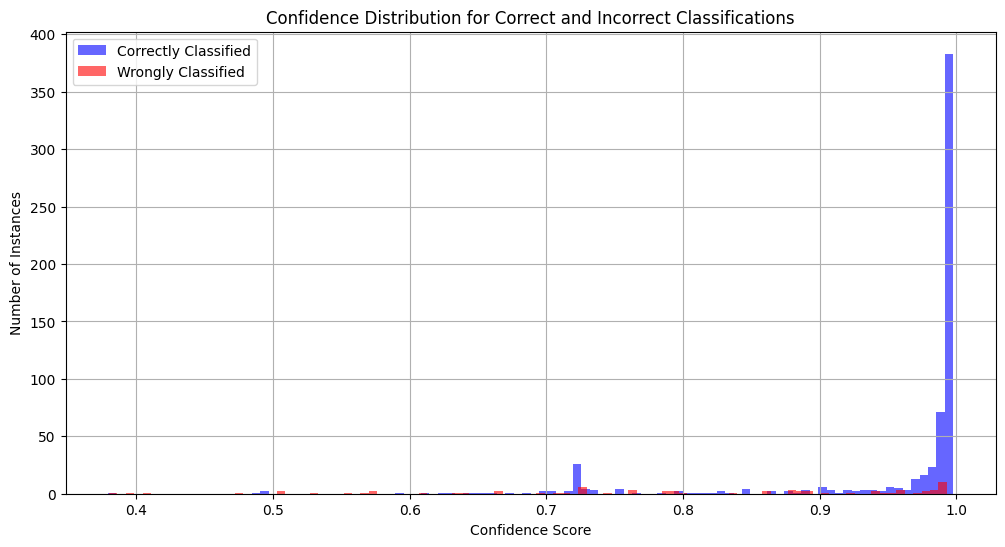

In [15]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(X_test)

# Get the confidence scores (max probability for each instance)
all_confidences = np.max(predictions, axis=1)

# Predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# True labels (assuming Y_test is one-hot encoded or in label form)
if Y_test.ndim == 2:  # If Y_test is one-hot encoded
    true_labels = np.argmax(Y_test, axis=1)
else:
    true_labels = Y_test

# Get confidence scores for correct and incorrect classifications
correct_confidences = all_confidences[predicted_labels == true_labels]
wrong_confidences = all_confidences[predicted_labels != true_labels]

# Plot histograms to visualize confidence score distribution
plt.figure(figsize=(12, 6))

# Histogram for correct classifications
plt.hist(correct_confidences, bins=100, alpha=0.6, color='blue', label='Correctly Classified')

# Histogram for incorrect classifications
plt.hist(wrong_confidences, bins=100, alpha=0.6, color='red', label='Wrongly Classified')

# Adding labels and title
plt.xlabel('Confidence Score')
plt.ylabel('Number of Instances')
plt.title('Confidence Distribution for Correct and Incorrect Classifications')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()